In [ ]:
pip install tsmoothie

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import math
import tensorflow as tf
from sklearn import model_selection
from sklearn import preprocessing
from tsmoothie.smoother import *

In [ ]:
#connecting to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Loading the dataset
df = pd.DataFrame(pd.read_csv('/content/drive/MyDrive/GEFCom2014-E.csv'))
df.dropna(inplace=True)
df.reset_index(inplace=True,drop=True)
display(df)

,Date,Hour,load,T
0,01-01-2006,1,3010.0,22.67
1,01-01-2006,2,2853.0,20.67
2,01-01-2006,3,2758.0,21.33
3,01-01-2006,4,2705.0,19.00
4,01-01-2006,5,2709.0,19.33
...,...,...,...,...
78883,31-12-2014,20,4012.0,18.00
78884,31-12-2014,21,3856.0,16.67
78885,31-12-2014,22,3671.0,17.00
78886,31-12-2014,23,3499.0,15.33


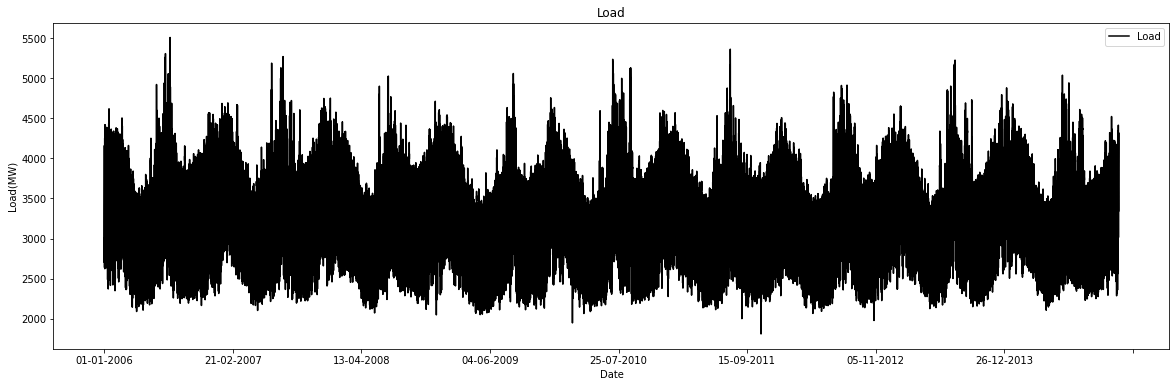

In [ ]:
#Visualizing the load data
df.set_index('Date')[['load']].plot(subplots=False,
                                    ylabel='Load(MW)',
                                    figsize=(20,6),
                                    title='Load',
                                    color='black')
 
plt.legend(['Load'],loc='upper right')

In [ ]:
#Smoothing the load data using a Kalman Smoother
smoother = KalmanSmoother(component='level_longseason', 
                          component_noise={'level':0.6,'longseason':0.6,'trend':0.6}, 
                          n_longseasons=365)
smoother.smooth(df[['load']].T)
smoother.smooth_data.reshape((len(df),))
smoothed_load = pd.DataFrame(smoother.smooth_data)
smoothed_load = smoothed_load.transpose()
smoothed_load.columns = ['load']
display(smoothed_load)

,load
0,2901.468914
1,2845.371619
2,2780.058712
3,2741.189969
4,2745.747702
...,...
78883,3999.209834
78884,3846.949981
78885,3683.568967
78886,3535.079751


In [ ]:
df['smoothed_load'] = smoothed_load['load']
display(df)

,Date,Hour,load,T,smoothed_load
0,01-01-2006,1,3010.0,22.67,2901.468914
1,01-01-2006,2,2853.0,20.67,2845.371619
2,01-01-2006,3,2758.0,21.33,2780.058712
3,01-01-2006,4,2705.0,19.00,2741.189969
4,01-01-2006,5,2709.0,19.33,2745.747702
...,...,...,...,...,...
78883,31-12-2014,20,4012.0,18.00,3999.209834
78884,31-12-2014,21,3856.0,16.67,3846.949981
78885,31-12-2014,22,3671.0,17.00,3683.568967
78886,31-12-2014,23,3499.0,15.33,3535.079751


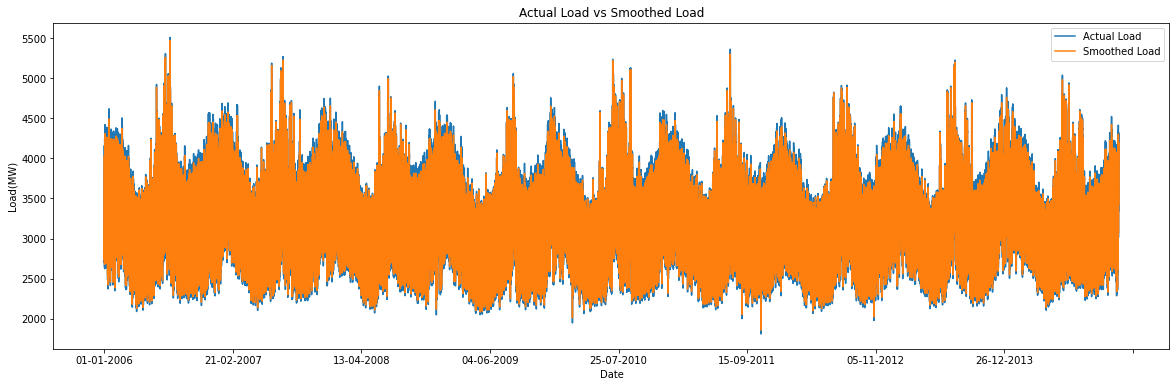

In [ ]:
#Visualizing Actual Load and Smoothed Load
df.set_index('Date')[['load','smoothed_load']].plot(subplots=False,
                                                    ylabel='Load(MW)',
                                                    figsize=(20,6),
                                                    title='Actual Load vs Smoothed Load')

plt.legend(['Actual Load','Smoothed Load'],loc='upper right')

In [ ]:
#Selecting the features which are to be the inputs to the model
df_input = df.iloc[:,[2,4]]
display(df_input)

,load,smoothed_load
0,3010.0,2901.468914
1,2853.0,2845.371619
2,2758.0,2780.058712
3,2705.0,2741.189969
4,2709.0,2745.747702
...,...,...
78883,4012.0,3999.209834
78884,3856.0,3846.949981
78885,3671.0,3683.568967
78886,3499.0,3535.079751


In [ ]:
#Scaling the input data using a MinMaxScaler to values in the range of 0 to 1.
scaler = preprocessing.MinMaxScaler()
scaled_data = scaler.fit_transform(df_input)
target = scaled_data[:,0]
features = scaled_data

In [ ]:
#Scaled Features
print(features)

[[0.32449256 0.2886719 ]
 [0.28200271 0.27314305]
 [0.25629229 0.25506313]
 ...
 [0.50338295 0.50517285]
 [0.45683356 0.46406807]
 [0.41515562 0.43491308]]


In [ ]:
#Scaled Target
print(target)

[0.32449256 0.28200271 0.25629229 ... 0.50338295 0.45683356 0.41515562]


In [ ]:
#Splitting the input data into training,validation and test sets
x_train,x_valid,y_train,y_valid=model_selection.train_test_split(features,
                                                                 target,
                                                                 test_size=(17520/len(df)),
                                                                 random_state=123,
                                                                 shuffle=False)
                                                                 
x_valid,x_test,y_valid,y_test=model_selection.train_test_split(x_valid,
                                                               y_valid,
                                                               test_size=(192/len(x_valid)),
                                                               random_state=123,
                                                               shuffle=False)

In [ ]:
#Sequencing the input data
batchs = 64
windowl = 24
num_features = 2
train_gen = tf.keras.preprocessing.sequence.TimeseriesGenerator(x_train,
                                                                y_train,
                                                                batch_size=batchs,
                                                                length=windowl,
                                                                sampling_rate=1)

valid_gen = tf.keras.preprocessing.sequence.TimeseriesGenerator(x_valid,
                                                                y_valid,
                                                                batch_size=batchs,
                                                                length=windowl,
                                                                sampling_rate=1)

test_gen = tf.keras.preprocessing.sequence.TimeseriesGenerator(x_test,
                                                               y_test,
                                                               batch_size=batchs,
                                                               length=windowl,
                                                               sampling_rate=1)

In [ ]:
#sliding window 0
print(train_gen[0][0][0]) #input
print(train_gen[0][1][0]) #output

[[0.32449256 0.2886719 ]
 [0.28200271 0.27314305]
 [0.25629229 0.25506313]
 [0.24194858 0.24430348]
 [0.24303112 0.24556516]
 [0.25493911 0.25903525]
 [0.28092016 0.28625807]
 [0.32395129 0.32800153]
 [0.38755074 0.38152451]
 [0.44844384 0.43297092]
 [0.48362652 0.4693154 ]
 [0.50392422 0.49097352]
 [0.50987821 0.49901377]
 [0.49499323 0.49577489]
 [0.48200271 0.49564292]
 [0.49120433 0.51440543]
 [0.57185386 0.56327618]
 [0.63545332 0.60189265]
 [0.61813261 0.59851869]
 [0.5834912  0.57036767]
 [0.54289581 0.52619191]
 [0.47225981 0.46283005]
 [0.39079838 0.39097732]
 [0.31772666 0.32443079]]
0.2630581867388363


In [ ]:
#sliding window 1
print(train_gen[0][0][1]) #input
print(train_gen[0][1][1]) #output

[[0.28200271 0.27314305]
 [0.25629229 0.25506313]
 [0.24194858 0.24430348]
 [0.24303112 0.24556516]
 [0.25493911 0.25903525]
 [0.28092016 0.28625807]
 [0.32395129 0.32800153]
 [0.38755074 0.38152451]
 [0.44844384 0.43297092]
 [0.48362652 0.4693154 ]
 [0.50392422 0.49097352]
 [0.50987821 0.49901377]
 [0.49499323 0.49577489]
 [0.48200271 0.49564292]
 [0.49120433 0.51440543]
 [0.57185386 0.56327618]
 [0.63545332 0.60189265]
 [0.61813261 0.59851869]
 [0.5834912  0.57036767]
 [0.54289581 0.52619191]
 [0.47225981 0.46283005]
 [0.39079838 0.39097732]
 [0.31772666 0.32443079]
 [0.26305819 0.27305519]]
0.23599458728010825


In [ ]:
#Model Creation and Training
model = tf.keras.Sequential() 
model.add(tf.keras.layers.LSTM(units=128,
                               input_shape=(windowl,num_features),
                               kernel_initializer='random_normal',
                               activity_regularizer=tf.keras.regularizers.l1(1e-4),
                               return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.LSTM(units=128,
                               kernel_initializer='random_normal',
                               activity_regularizer=tf.keras.regularizers.l1(1e-4),
                               return_sequences=False))
model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Dense(1,activation='relu'))

lr_schedule=tf.keras.optimizers.schedules.InverseTimeDecay(
  initial_learning_rate=0.001,
  decay_steps=3000,
  decay_rate=0.9)

opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=1,
                                                  min_delta=0.0001,
                                                  mode='min',
                                                  restore_best_weights=True)

model.compile(optimizer=opt,loss='mae')

hist = model.fit(train_gen,
                 epochs=30,
                 validation_data=valid_gen,
                 shuffle=False,
                 callbacks=[early_stopping])

Epoch 1/30
959/959 [==============================] - 11s 9ms/step - loss: 0.0570 - val_loss: 0.0368
Epoch 2/30
959/959 [==============================] - 8s 8ms/step - loss: 0.0309 - val_loss: 0.0208
Epoch 3/30
959/959 [==============================] - 7s 8ms/step - loss: 0.0244 - val_loss: 0.0164
Epoch 4/30
959/959 [==============================] - 7s 8ms/step - loss: 0.0210 - val_loss: 0.0153
Epoch 5/30
959/959 [==============================] - 8s 8ms/step - loss: 0.0186 - val_loss: 0.0114
Epoch 6/30
959/959 [==============================] - 8s 8ms/step - loss: 0.0166 - val_loss: 0.0089
Epoch 7/30
959/959 [==============================] - 8s 8ms/step - loss: 0.0154 - val_loss: 0.0103


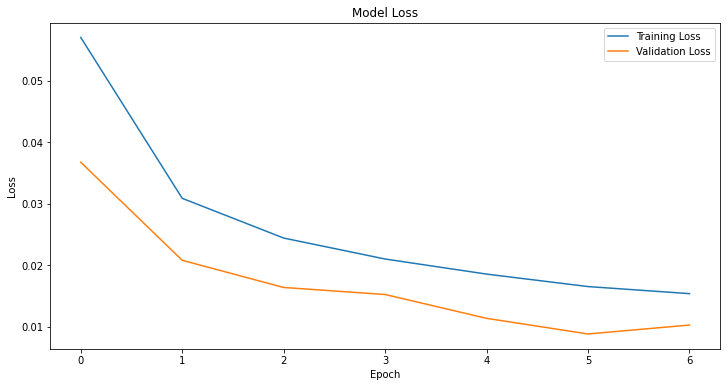

In [ ]:
#Plotting Training and Validation loss
plt.figure(figsize=(12,6))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

In [ ]:
#Evaluating the model performance
model.evaluate(test_gen,verbose=1)

3/3 [==============================] - 0s 5ms/step - loss: 0.0080


0.007958918809890747

In [ ]:
#Forecasting Load Demand
predicts = model.predict(test_gen)

In [ ]:
df_pred = pd.concat([pd.DataFrame(predicts),pd.DataFrame(x_test[:,1:][windowl:])],
                    axis=1)

In [ ]:
#Bringing the scaled values back to the original range
revt = scaler.inverse_transform(df_pred)

In [ ]:
df_final = df[predicts.shape[0]*-1:]

In [ ]:
df_final['Predictions'] = revt[:,0].copy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
#Calculating Forecast Error using MAPE,MAE and RMSE
y_true = df_final['load']
y_pred = df_final['Predictions']
mape = float(tf.keras.losses.mean_absolute_percentage_error(y_true,y_pred))
mae = float(tf.keras.losses.mean_absolute_error(y_true, y_pred))
rmse = math.sqrt(tf.keras.losses.mean_squared_error(y_true,y_pred))
print("Mean Absolute Percentage Error = ",mape)
print("Mean Absolute Error = ",mae)
print("Root Mean Squared Error = ",rmse)

Mean Absolute Percentage Error =  0.7411893209898321
Mean Absolute Error =  25.00346690522773
Root Mean Squared Error =  35.9556106039545


In [ ]:
#Load Forecasts
df_final.set_index('Date',inplace=True)
display(df_final)

,Hour,load,T,smoothed_load,Predictions
Date,,,,,
25-12-2014,1,2520.0,40.67,2564.718451,2578.036071
25-12-2014,2,2394.0,40.67,2436.549390,2411.526620
25-12-2014,3,2316.0,41.33,2359.829844,2327.515841
25-12-2014,4,2287.0,41.33,2336.130215,2296.549884
25-12-2014,5,2312.0,42.67,2371.820866,2332.043242
...,...,...,...,...,...
31-12-2014,20,4012.0,18.00,3999.209834,4051.584179
31-12-2014,21,3856.0,16.67,3846.949981,3881.075019
31-12-2014,22,3671.0,17.00,3683.568967,3689.681020


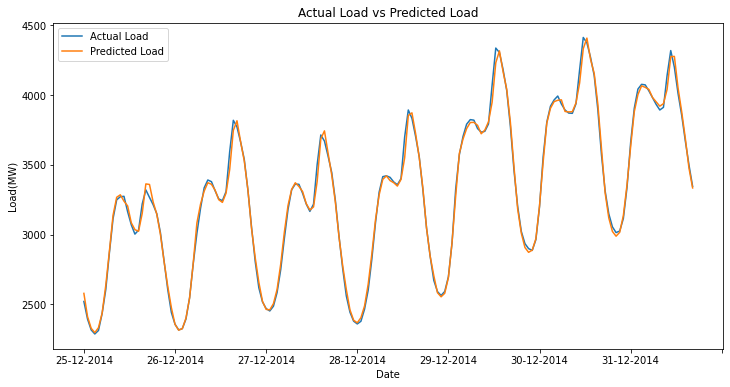

In [ ]:
#Plotting Predicted Load vs Actual Load(1 week predictions)
df_final[['load','Predictions']].plot(subplots=False,
                                      figsize=(12,6),
                                      ylabel='Load(MW)',
                                      title='Actual Load vs Predicted Load')

plt.legend(['Actual Load','Predicted Load'],loc='upper left')

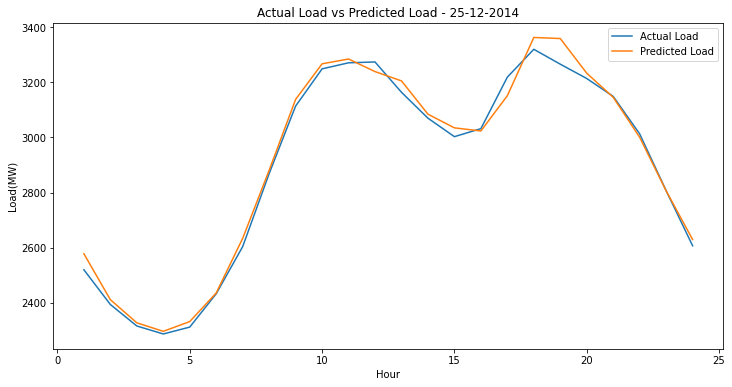

In [ ]:
#Plotting Predicted Load vs Actual Load(1 day predictions)
df_final.set_index('Hour')[['load','Predictions']][:24].plot(subplots=False,
                                                             figsize=(12,6),
                                                             ylabel='Load(MW)',
                                                             title='Actual Load vs Predicted Load - 25-12-2014')

plt.legend(['Actual Load','Predicted Load'],loc='upper right')